In [2]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from basics import *

%matplotlib inline

In [3]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Speech Translation

BLEU scores with varying amount of training data used

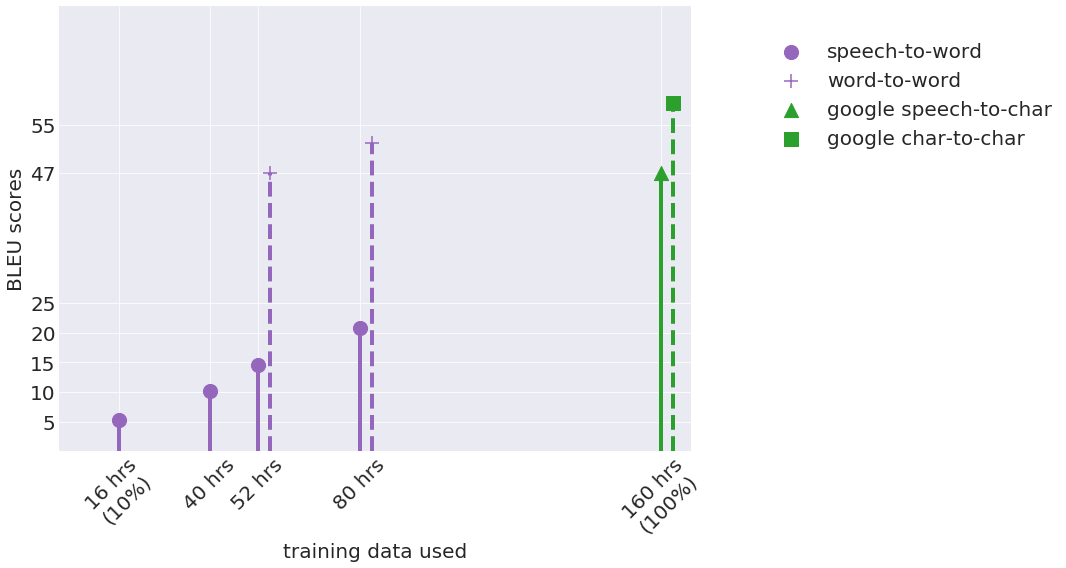

In [45]:
fig, ax = plt.subplots(figsize=(10,8),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

bar_y = np.array([5.26, 10.22, 14.5, 20.82])
bar_x = np.array([10, 25, 33, 50])
x_scale = np.array([10, 25, 33, 50, 100])

word2word_x = [35, 52]
word2word_y = [47, 52]

google_char2char_x = [102]
google_char2char_y = [58.7]

# x_labels = ["{0:d} hrs\n({1:d}%)".format(int(160 * (i/100)), i) for i in x_scale]
# x_labels = ["{0:d} hrs".format(int(160 * (i/100))) for i in x_scale]
x_labels = ['16 hrs\n(10%)', '40 hrs', '52 hrs', '80 hrs', '160 hrs\n(100%)']

bar_colors = [tableau20[0]]*6

ax.scatter(x=bar_x, y=bar_y, s=200, marker='o' , label="speech-to-word", c=tableau20[8])

# word-to-word level
ax.scatter(x=word2word_x, y=word2word_y, s=200, marker='+' , label="word-to-word", c=tableau20[8])

# google
ax.scatter(x=[100], y=[47], s=200, marker='^' , label="google speech-to-char", c=tableau20[4])
ax.scatter(x=google_char2char_x, y=google_char2char_y, s=200, marker='s' , label="google char-to-char", c=tableau20[4])

# -------------------------------------------------------------
# # old code
# ax = sns.regplot(x=bar_x, y=bar_y, ax=ax, 
#                  scatter_kws={"alpha":1.0, 's':200}, 
#                  line_kws={"linestyle":"--"},
#                  color=tableau20[8], fit_reg=False,
#                 label="our models")
# -------------------------------------------------------------

markerline, stemlines, baseline = ax.stem(bar_x, bar_y, linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem(word2word_x, word2word_y, linefmt='--', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem([100], [47], linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem(google_char2char_x, google_char2char_y, linefmt='--', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)


plt.xticks(x_scale, x_labels, rotation=45, fontsize=16)
plt.yticks(list(range(5,30,5))+[47, 55], rotation=0, fontsize=20)
ax.set_xlabel('training data used', size=20)
ax.set_ylabel('BLEU scores', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(20)

plt.legend(bbox_to_anchor=(1.6, 0.96), framealpha=0, fontsize=20)
plt.ylim(0,75)
plt.xlim(0,105)

sns.despine(left=True, bottom=True)

fig.tight_layout()

fig.savefig(filename="bleu_scores.pdf", dpi=300)

### Sample translation

In [5]:
sample_translations = {
    'reference' : """i ' m from puerto rico but i live here in denver colorado""",
    '50%' : """i ' m from puerto rico but i live here in canada""",
    '25%' : """and i ' m four five hours here in the same time here in canada""",
    '10%' : """and i was the united states i was in the united states""",
    "previous best" : """i ' m from puerto rico but i live here in denver colorado""",
    'google' : """i'm from puerto rico but i live here in denver colorado"""   
}

In [6]:
print("{0:20s} | {1:<60s}".format("model", "translation"))
print("-"*80)
print("\n".join(["{0:20s} | {1:60s}".format(k, v) for k, v in sample_translations.items()]))

model                | translation                                                 
--------------------------------------------------------------------------------
reference            | i ' m from puerto rico but i live here in denver colorado   
50%                  | i ' m from puerto rico but i live here in canada            
25%                  | and i ' m four five hours here in the same time here in canada
10%                  | and i was the united states i was in the united states      
previous best        | i ' m from puerto rico but i live here in denver colorado   
google               | i'm from puerto rico but i live here in denver colorado     


## English word spotting

In [7]:
from IPython.display import Image

### Selected topics and their counts in the dev set

Number of topics = 28

total number of utterances in which topic words occur = 217
total utterances in dev set = 3977

To spot a keyword, we **stem** it, and then count the utterances in which the keyword occurs (using the translations).

**Note**: For this task, **we predict whether an utterance contains a keyword or not**. If there are multiple instances of the keyword in an utterance, only one will be counted


total tokens in dev set = 170,346

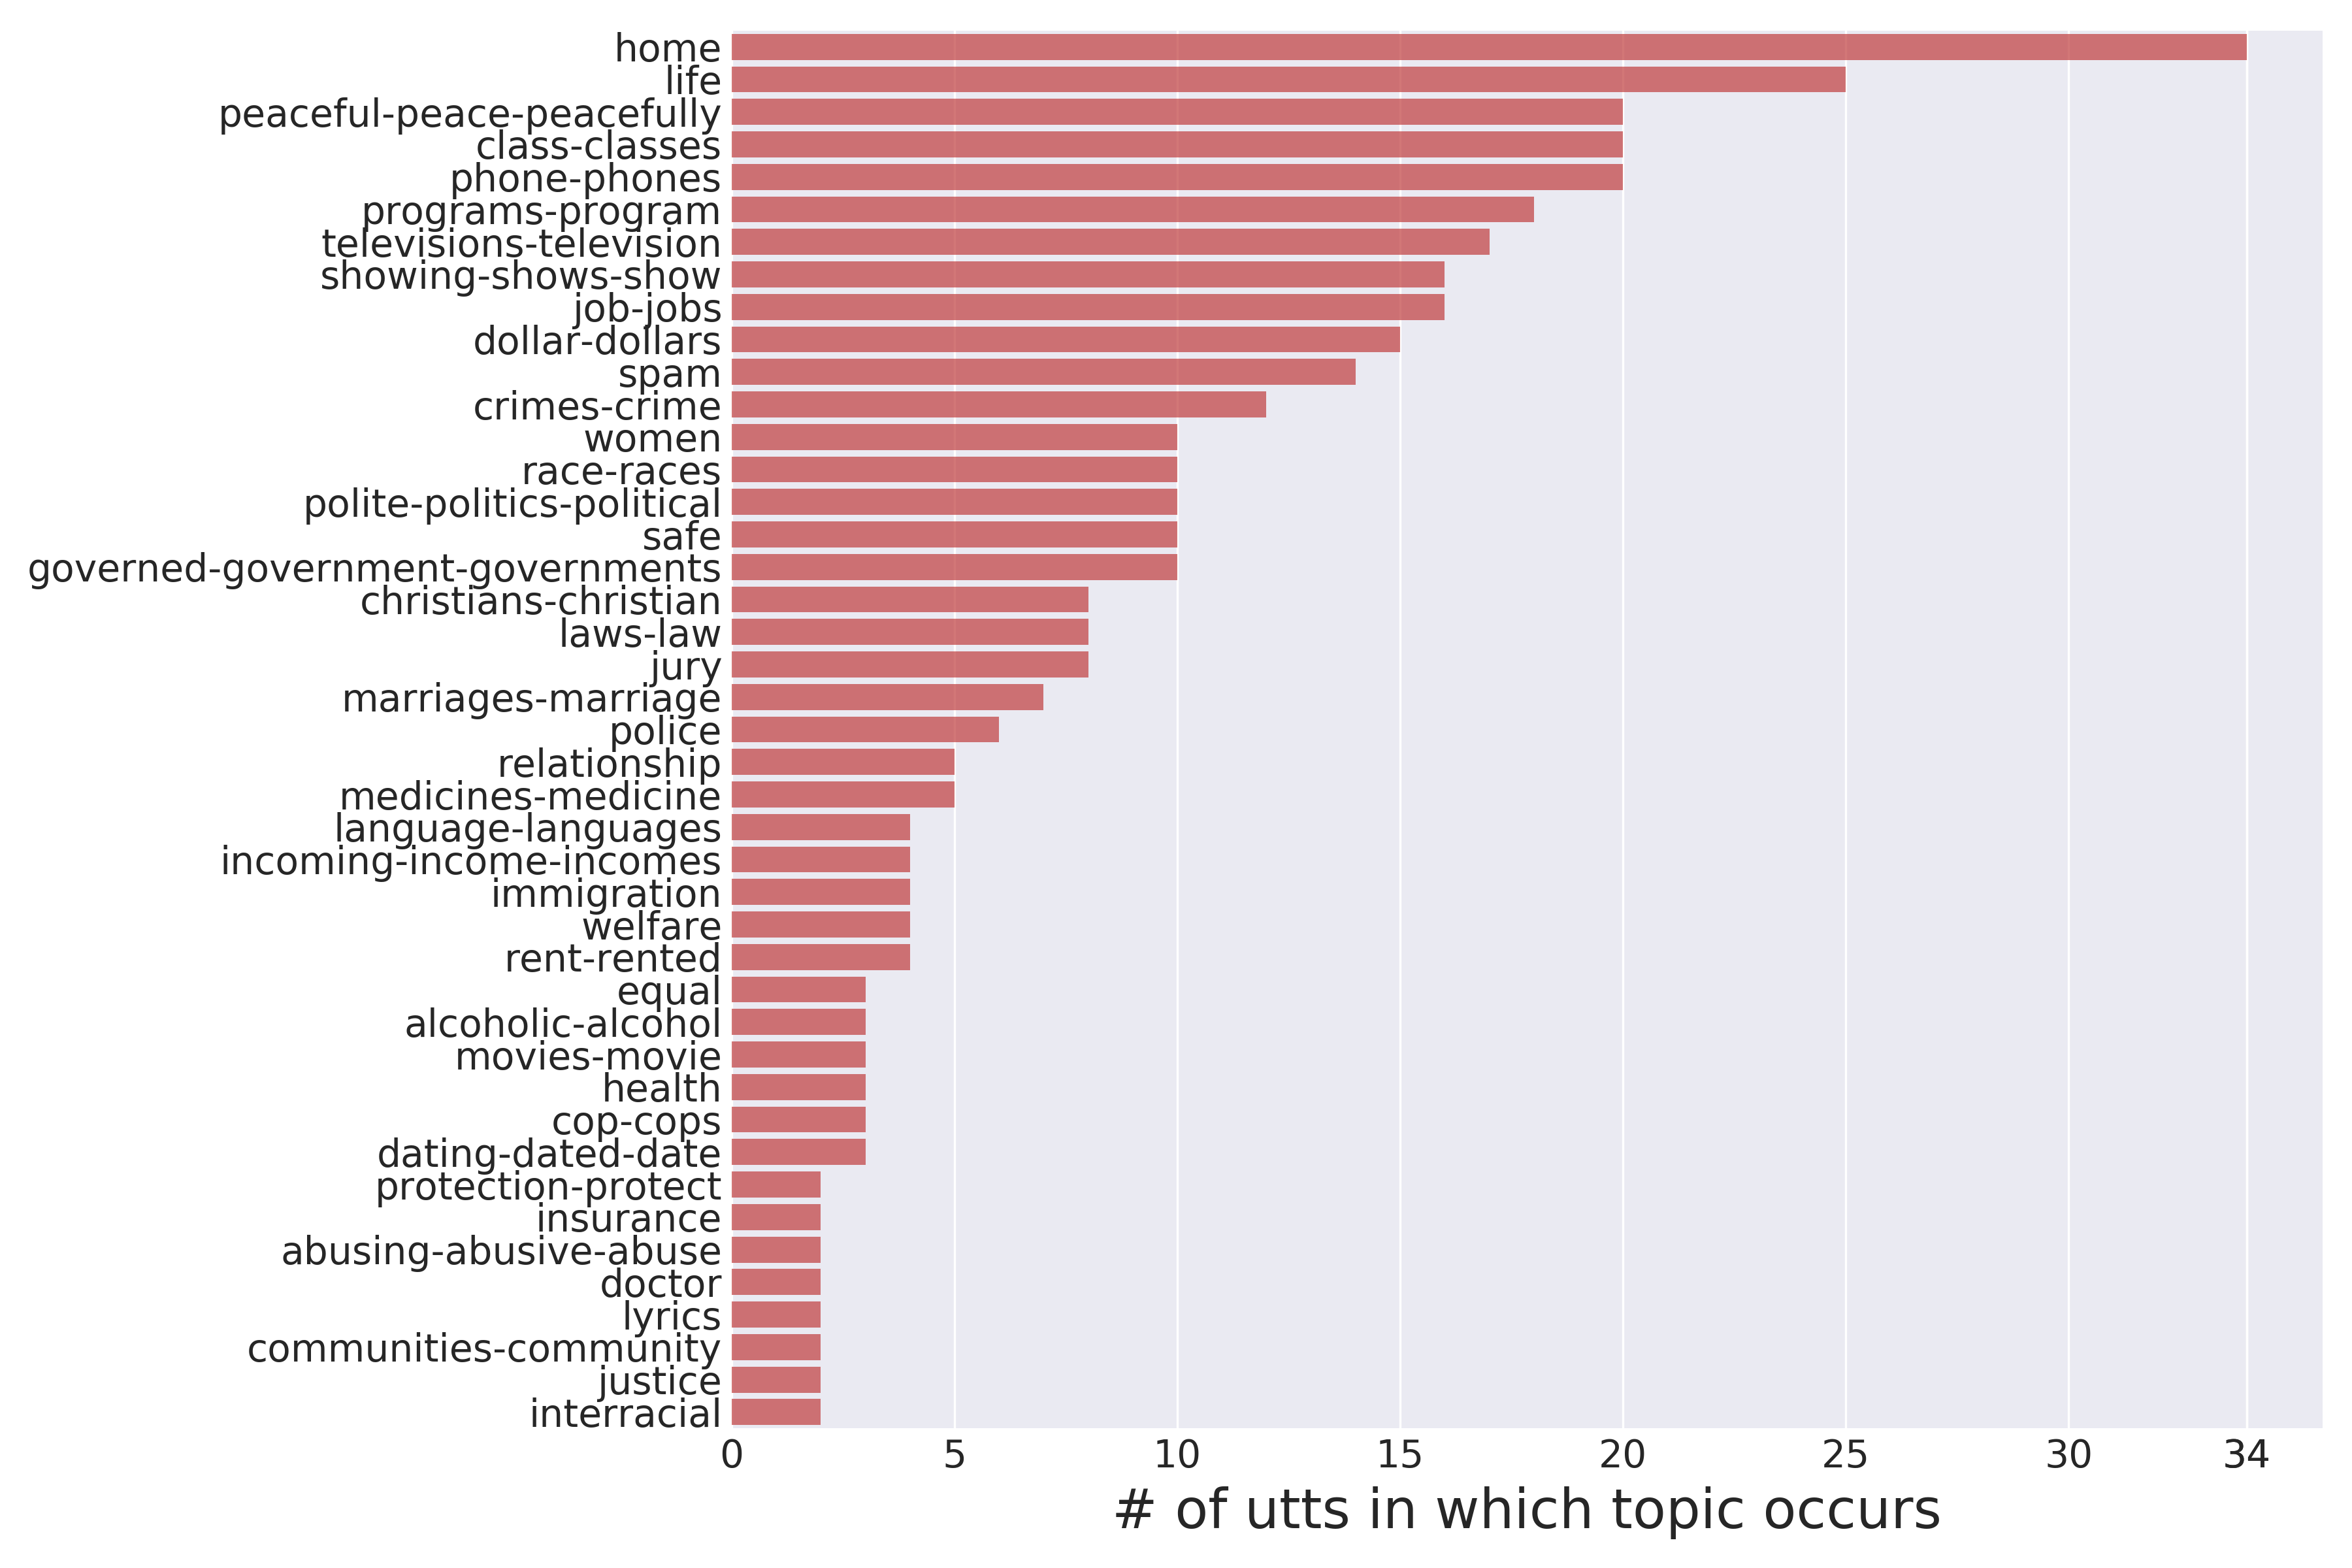

In [8]:
Image("../criseslex/sel_topics.png")

### Precision

In [9]:
topics_prec_y = np.array([6.38, 23.8, 48.28])
topics_prec_x = np.array([10, 25, 50])
topics_old_prec_y = [61.7]
topics_google_prec_y = [75]

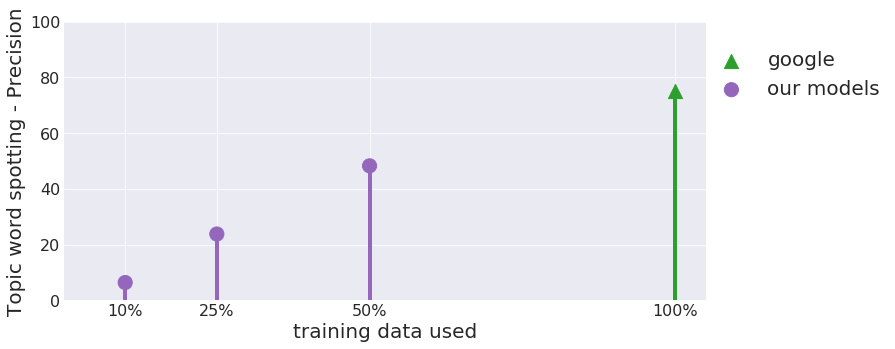

In [25]:
-

### Recall

In [27]:
topics_rec_y = np.array([1.38, 9.68, 38.71])
topics_rec_x = np.array([10, 25, 50])
topics_old_rec_y = [49.7]
topics_google_rec_y = [69]

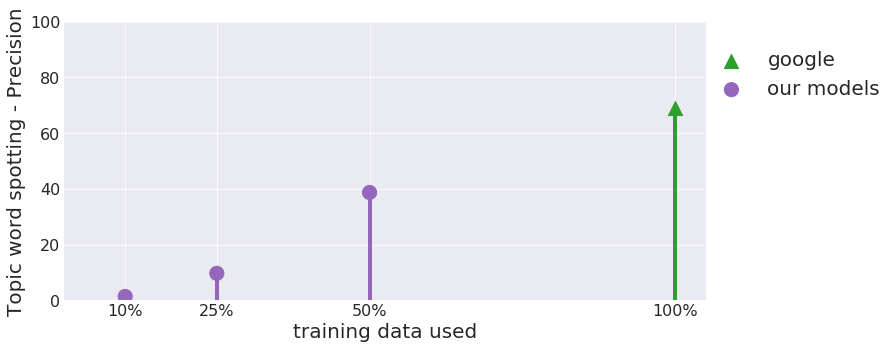

In [34]:
fig, ax = plt.subplots(figsize=(10,5),nrows=1, ncols=1, sharey=True)
sns.set_style("darkgrid")

x_scale = np.array([10, 25, 50, 100])
x_labels = ["{0:d}%".format(i) for i in x_scale]

bar_colors = [tableau20[8]]*6

ax.scatter(x=[100], y=topics_google_rec_y, s=200, marker='^' , label="google", c=tableau20[4])
# ax.scatter(x=[100], y=topics_old_prec_y, s=200, marker='^' , label="previous best", c=tableau20[0])

ax.scatter(x=topics_rec_x, y=topics_rec_y, s=200, marker='o' , label="our models", c=bar_colors)

markerline, stemlines, baseline = ax.stem(topics_rec_x, topics_rec_y, linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[8], 'linewidth', 4)

markerline, stemlines, baseline = ax.stem([100], topics_google_rec_y, linefmt='-', markerfmt=' ', basefmt=' ')
plt.setp(stemlines, 'color', tableau20[4], 'linewidth', 4)

plt.xticks(x_scale, x_labels, rotation=0)
ax.set_xlabel('training data used', size=20)
ax.set_ylabel('Topic word spotting - Precision', size=20)
for i in ax.get_xticklabels()+ax.get_yticklabels():
    i.set_fontsize(16)

plt.yticks(fontsize=16, rotation=0)

plt.ylim(0,100)
plt.xlim(0,105)

sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(1.3, 0.96), framealpha=0, fontsize=20)    

fig.tight_layout()
fig.savefig(filename="topics_recall.png", dpi=300)